In [2]:
# ! pip install gdown
# ! pip install zipfile
# ! pip install matplotlib
# ! pip install ultralyctics
# ! pip install cv2
# ! pip install ultralytics

import gdown
import zipfile
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
import os
import cv2  # image resizing

In [1]:
! gdown --id 1XuAgWm-gR3NCccvUlcOIYJFVjkWRSBrP

c:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\.venv\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XuAgWm-gR3NCccvUlcOIYJFVjkWRSBrP
From (redirected): https://drive.google.com/uc?id=1XuAgWm-gR3NCccvUlcOIYJFVjkWRSBrP&confirm=t&uuid=3acc7fef-0670-4b8b-bbd4-7d3a75634226
To: c:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11.zip

  0%|          | 0.00/1.16G [00:00<?, ?B/s]
  0%|          | 524k/1.16G [00:00<07:33, 2.57MB/s]
  0%|          | 1.57M/1.16G [00:00<03:39, 5.29MB/s]
  0%|          | 4.19M/1.16G [00:00<01:35, 12.1MB/s]
  1%|          | 9.44M/1.16G [00:00<00:47, 24.4MB/s]
  1%|          | 14.2M/1.16G [00:00<00:36, 31.4MB/s]
  2%|▏         | 17.8M/1.16G [00:00<00:35, 32.2MB/s]
  2%|▏         | 21.5M/1.16G [00:00<00:47, 23.8MB/s]
 

In [4]:
zip_file = zipfile.ZipFile('Food-11.zip')
zip_file.extractall()
zip_file.close()

In [5]:
# Renaming folders to match YOLO standards/preference(?)
dataset_path = "Food-11"
rename_dict = {
    "training": "train",
    "evaluation": "test",
    "validation": "val"
}
# Rename folders
for old_name, new_name in rename_dict.items():
    if os.path.exists(f"{dataset_path}/{new_name}"):
        continue
    old_path = os.path.join(dataset_path, old_name)
    new_path = os.path.join(dataset_path, new_name)
        
    os.rename(old_path, new_path)
    print(f"Renamed '{old_name}' -> '{new_name}'")

Renamed 'training' -> 'train'
Renamed 'evaluation' -> 'test'
Renamed 'validation' -> 'val'


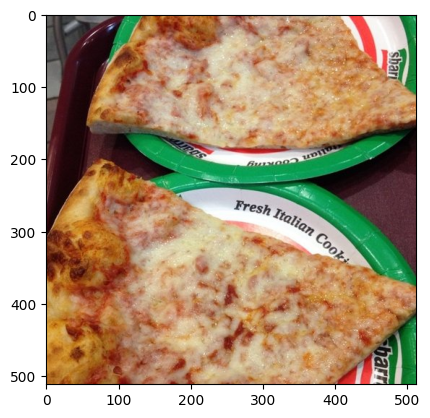

In [6]:
plt.imshow(plt.imread("Food-11/train/Bread/5.jpg"))

In [7]:
# Check dataset image max size
dataset_path = "Food-11/train"  # Change for valid/test sets

max_width = 10
max_height = 10
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = plt.imread(img_path)
      h, w, _ = img.shape
      if h > max_height:
        max_height = h
        print(f"New max height: {max_height}")
      if w > max_width:
        max_width = w
        print(f"New max width: {max_width}")
    print(f"{class_folder} Done!")
  
print(f"\nFinal max height: {max_height}")
print(f"Final max width: {max_width}")

New max height: 512
New max width: 512
Bread Done!
New max width: 670
New max height: 540
New max width: 960
New max height: 1132
New max width: 1600
New max height: 1300
New max height: 1358
New max height: 2100
New max width: 2800
New max height: 2304
New max width: 3456
New max height: 2560
New max height: 4614
New max width: 3600
Dairy product Done!
Dessert Done!
Egg Done!
Fried food Done!
Meat Done!
Noodles-Pasta Done!
Rice Done!
Seafood Done!
Soup Done!
New max height: 4912
New max width: 7360
Vegetable-Fruit Done!

Final max height: 4912
Final max width: 7360


In [ ]:
# PROCESSING IMAGES
  # resizing: for uniform image sizes (set to 640x640)
  # augmentation: for balancing of training dataset

import numpy as np
import albumentations as A
import random

dataset_path = "Food-11"

# Target image size
TARGET_SIZE = (640, 640)

# Maximum images per class
MAX_IMAGES_PER_CLASS = 1500

# Sequential augmentation functions 
transform = A.Compose([
    A.Rotate(limit=20), # Randomly rotates the image between -20 and +20 degrees
    A.HorizontalFlip(p=0.5), # probability of it happening (0.5: 50% chance of applying)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Function to resize (640) and augment images 
def process_images(subset_path, do_augment):
    for class_folder in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_folder)
        save_path = os.path.join(subset_path, class_folder)

        # Get list of images
        img_files = os.listdir(class_path)
        original_count = len(img_files)

        # Resize images
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            resized_img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(img_path, resized_img)  # Overwrite original image

        # If does not need augmentation, skip
        if (not do_augment):
            continue

        # Calculate how many more images are needed
        needed_augmentations = max(0, MAX_IMAGES_PER_CLASS - original_count)

        # Generate only the required number of augmented images
        for i in range(needed_augmentations):
            img_name = random.choice(img_files)  # Pick a random image
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # transform image to make augmented images
            # ['image'] used because transform returns dictionary and we only want the image
            augmented = transform(image=img)['image']
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(save_path, aug_img_name), augmented)

        print(f"{class_folder} processing complete now with {min(MAX_IMAGES_PER_CLASS, original_count + needed_augmentations)} images")

# Process train, val, and test sets (augment only train)
# Resize images in train, val, and test sets
for subset in ["train", "val", "test"]:
    subset_path = os.path.join(dataset_path, subset)
    print(f"Processing images in {subset_path} ...")
    process_images(subset_path, (subset == "train")) # Augment only training set

Processing images in Food-11\train ...
Bread processing complete now with 1500 images
Dairy product processing complete now with 1500 images
Dessert processing complete now with 1500 images
Egg processing complete now with 1500 images
Fried food processing complete now with 1500 images
Meat processing complete now with 1500 images
Noodles-Pasta processing complete now with 1500 images
Rice processing complete now with 1500 images
Seafood processing complete now with 1500 images
Soup processing complete now with 1500 images
Vegetable-Fruit processing complete now with 1500 images
Processing images in Food-11\val ...
Processing images in Food-11\test ...


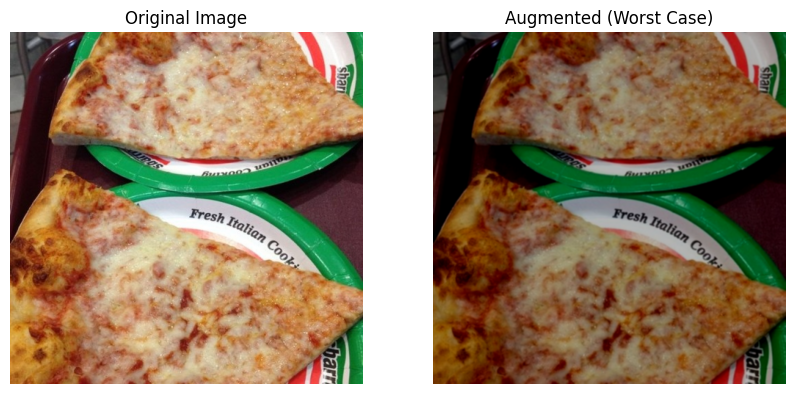

In [9]:
# Load an image (change path to your image)
img_path = "Food-11/train/Bread/5.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

# Define the augmentations with extreme settings
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),  # Always applies
    A.GaussianBlur(blur_limit=3, p=1.0),  # Always applies
])

# Apply augmentation
augmented = transform(image=img)['image']

# Show original and augmented images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented)
plt.title("Augmented (Worst Case)")
plt.axis("off")

plt.show()

In [3]:
base_model = YOLO("yolo11n-cls.pt")

In [11]:
print(base_model.info)

<bound method Model.info of YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [12]:
base_model.train(data="Food-11", epochs=10, imgsz=640, freeze=10)

Ultralytics 8.3.94  Python-3.13.1 torch-2.6.0+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)
engine\trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=Food-11, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\train... 16500 images, 0 corrupt: 100%|██████████| 16500/16500 [00:15<00:00, 1090.24it/s]


train: New cache created: C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\train.cache


val: Scanning C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\val... 3430 images, 0 corrupt: 100%|██████████| 3430/3430 [00:03<00:00, 884.02it/s]


val: New cache created: C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\classify\train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.50s/it]

                   all      0.712      0.971



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:43<00:00,  1.52s/it]

                   all      0.787      0.983

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:43<00:00,  1.51s/it]

                   all      0.791      0.985

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.51s/it]

                   all      0.817      0.987

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:43<00:00,  1.51s/it]

                   all      0.829      0.989

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.51s/it]

                   all      0.831       0.99

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.51s/it]

                   all      0.835       0.99

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.50s/it]

                   all      0.844      0.992

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.50s/it]

                   all      0.845      0.993

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G     0.4672          4        640: 100%|██████████| 1032/1032 [18:08<00:00,  1.05s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:42<00:00,  1.50s/it]

                   all      0.848      0.992

10 epochs completed in 3.486 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.2MB

Validating runs\classify\train\weights\best.pt...
Ultralytics 8.3.94  Python-3.13.1 torch-2.6.0+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)


YOLO11n-cls summary (fused): 47 layers, 1,540,115 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\train... found 16500 images in 11 classes  
val: C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\val... found 3430 images in 11 classes  
test: C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\test... found 3347 images in 11 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 108/108 [02:14<00:00,  1.25s/it]


                   all      0.847      0.992
Speed: 0.0ms preprocess, 32.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002060CC8EC60>
curves: []
curves_results: []
fitness: 0.9192419946193695
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8469387888908386, 'metrics/accuracy_top5': 0.9915452003479004, 'fitness': 0.9192419946193695}
save_dir: WindowsPath('runs/classify/train')
speed: {'preprocess': 0.000597259474512829, 'inference': 32.17322367346976, 'loss': 2.647230485043524e-05, 'postprocess': 7.758017223543533e-05}
task: 'classify'
top1: 0.8469387888908386
top5: 0.9915452003479004

In [1]:
print(base_model.info)

NameError: name 'base_model' is not defined

In [8]:
data_yaml = f"""
train: train
val: test

nc: 11
names: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
"""

with open("Food-11/data.yaml", "w") as file:
    file.write(data_yaml)

In [9]:
metrics = base_model.val(data='Food-11/data.yaml')
print(metrics)

Ultralytics 8.3.94  Python-3.13.1 torch-2.6.0+cpu CPU (AMD Ryzen 7 5700G with Radeon Graphics)


val: Scanning C:\Users\jpark\OneDrive\Documents\Codes\python\Transfer_Learning\Food-11\test... 3347 images, 0 corrupt: 100%|██████████| 3347/3347 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 210/210 [00:32<00:00,  6.39it/s]


                   all          0   0.000896
Speed: 0.0ms preprocess, 3.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val12
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000025D7123C410>
curves: []
curves_results: []
fitness: 0.00044816252193413675
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.0, 'metrics/accuracy_top5': 0.0008963250438682735, 'fitness': 0.00044816252193413675}
save_dir: WindowsPath('runs/classify/val12')
speed: {'preprocess': 0.0011610995334232783, 'inference': 3.650632058611139, 'loss': 9.348665116160599e-05, 'postprocess': 0.00016187633107262456}
task: 'classify'
top1: 0.0
top5: 0.0008963250438682735


In [35]:
import shutil

shutil.copyfile("runs/classify/train/weights/best.pt", "yolo_food_11_best.pt")

'yolo_food_11_best.pt'

In [ ]:
import matplotlib.pyplot as plt
import random

test_path = "Food-11/test/"
test_folder = os.listdir(test_path)
class_names = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
test_image_class = []

images = []
for food_class in test_folder:
  test_image_class.append(food_class)
  image_files = [f for f in os.listdir(test_path+"/"+food_class) if f.endswith('.jpg')]
  num_images = len(image_files)
  random_image_name = str(random.randint(1, num_images))
  image = test_path + "/" + food_class + "/" + random_image_name + ".jpg"
  images.append(image)

results = base_model(images)
for i in range(len(results)):
  plt.imshow(plt.imread(images[i]))
  plt.title(f"Predicted: {class_names[results[i].probs.top1]},    Actual: {test_image_class[i]}")
  plt.axis("off")
  plt.show()